In [1]:
import json
import csv

import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
import math
import pickle
import sys
sys.path.append("../../")

import implicitmodules.torch as dm
import PIL
from PIL import Image
torch.set_default_dtype(torch.float32)

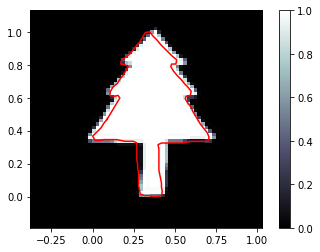

In [5]:
path_datafiles = '/home/gris/Data/2DShapes/'
path_names = path_datafiles + 'NamesPLAINTEXT/'

names = []
with open(path_names + 'labels.txt', 'r') as namelist:
    for line in namelist:
        names.append(line[:-1])

ind_shape = 21

names_subj = []
with open(path_names + 'ShapeNames/' + names[ind_shape] + '.txt', 'r') as namelist:
    for line in namelist:
        names_subj.append(line[:-1])


ind_subj = 0
path_subj = path_datafiles + 'ShapesJSON/Shapes/' + names_subj[ind_subj] + '.json'
#subj = 

list_subj = []
list_indi_tri = []
list_majo = []
for ind_subj in range(8):
    path_subj = path_datafiles + 'ShapesJSON/Shapes/' + names_subj[ind_subj] + '.json'
    with open(path_subj) as f:
        subj_dict = json.load(f)
        Npts = len(subj_dict['points'])
        subj = []
        for i in range(Npts-1):
            subj.append([subj_dict['points'][i]['x'], subj_dict['points'][i]['y']])

        list_subj.append(np.array(subj))
        
        indi_tri = []
        Ntri = len(subj_dict['triangles'])
        for i in range(Ntri):
            indi_tri.append([subj_dict['triangles'][i]['p1'],subj_dict['triangles'][i]['p2'],subj_dict['triangles'][i]['p3']])
        list_indi_tri.append(np.array(indi_tri))
     
    path_majo = path_datafiles + 'MajorityJSON/Majority/' + names_subj[ind_subj] + '.json'
    with open(path_majo) as f:
        list_majo.append(json.load(f))

ind_subj_source = 0
ind_subj_target = 7

source = torch.tensor(list_subj[ind_subj_source], dtype=torch.float32)
target = torch.tensor(list_subj[ind_subj_target], dtype=torch.float32)

arrsource = np.loadtxt('../../data/tree01_resized.txt')
arrtarget = np.loadtxt('../../data/tree08_resized.txt')


source_image = dm.Models.DeformableImage(torch.tensor(arrsource), output='bitmap', extent='match')
source_image = torch.tensor(np.array(np.flip(source_image.bitmap.numpy())), dtype=torch.float32)

target_image = dm.Models.DeformableImage(torch.tensor(arrtarget), output='bitmap', extent='match')
target_image = torch.tensor(np.array(np.flip(target_image.bitmap.numpy())), dtype=torch.float32)


extent_source = dm.Utilities.AABB( -0.38, 1.03, -0.19, 1.13)

plt.imshow(source_image.numpy(), origin='lower', cmap='bone', extent=extent_source.totuple())
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], 'r')
plt.colorbar()

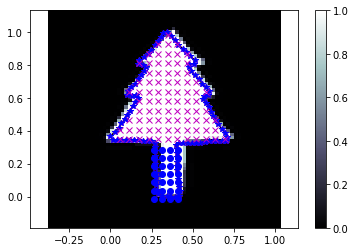

In [6]:
target_image.shape

extent_target = dm.Utilities.AABB( -0.38, 1.03, -0.19, 1.13)
#target_image = dm.Utilities.load_greyscale_image( path_datafiles + 'Images/tree08.png', origin='lower')
plt.imshow(target_image, origin='lower', cmap='bone', extent=extent_target.totuple())
#plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'r')
plt.colorbar()

aabb = dm.Utilities.aabb.AABB.build_from_points(source)

aabb.scale_([1.5, 2])

aabb_source = dm.Utilities.AABB.build_from_points(source)
density = 300
#points_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, density, shape=source)


indi_top0 = range(0, 67)
indi_top1 = range(97, 112)
#indi_left0 = range(0, 28)
#indi_left1 = range(80, 104)
indi_bottom = range(67, 97)


part_top = np.concatenate([source[indi_top0, :], source[indi_top1, :]], axis = 0)
#part_top = source[indi_left, :]
part_bottom = source[indi_bottom, :]

plt.plot(source[:,0], source[:,1], 'k')
plt.plot(part_top[:,0], part_top[:,1], '*m')
plt.plot(part_bottom[:,0], part_bottom[:,1], '*r')

col = ['k', 'm', 'g']
#plt.plot(subj[:,0], subj[:,1])
#for i in range(np.shape(indi_tri)[0]):
    #plt.plot(subj[indi_tri[i],0], subj[indi_tri[i],1], col[majo_dict['majority'][i]])
    #t1 = plt.Polygon(subj[indi_tri[i],:], color=col[majo_dict['majority'][i]])
    
plt.axis('equal')

aabb_source = dm.Utilities.AABB.build_from_points(source)
points_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, density, shape=source)
points_growthtop = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, density, shape=torch.tensor(part_top), intersect=True)
#points_growthbottom = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, density, shape=torch.tensor(part_bottom), intersect=True)


aabb_bottom = dm.Utilities.AABB(0.27, 0.43, 0.,0.3)

points_growthbottom = aabb_bottom.scale(1.1).fill_uniform_density(400)

plt.imshow(source_image.numpy(), origin='lower', cmap='bone', extent=extent_source.totuple())
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '*b')
plt.plot(points_growthtop[:,0], points_growthtop[:,1], 'xm')
plt.plot(points_growthbottom[:,0], points_growthbottom[:,1], 'ob')
plt.axis('equal')

points_growth = torch.cat([points_growthtop, points_growthbottom])

rot_growth = torch.stack([dm.Utilities.rot2d(0.)]*points_growth.shape[0], axis=0)


#%matplotlib qt5
C_top = torch.zeros(points_growth.shape[0], 2, 2)
C_top[:points_growthtop.shape[0], 0, 0] = 1.
C_top[:points_growthtop.shape[0], 1, 1] = 1.

/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


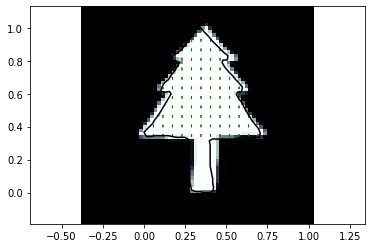

In [9]:

indi_top0 = range(0, 67)
indi_top1 = range(97, 112)
#indi_left0 = range(0, 28)
#indi_left1 = range(80, 104)
indi_bottom = range(67, 97)


part_top = np.concatenate([source[indi_top0, :], source[indi_top1, :]], axis = 0)
#part_top = source[indi_left, :]
part_bottom = source[indi_bottom, :]

aabb_source = dm.Utilities.AABB.build_from_points(source)
points_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, density, shape=source)
points_growthtop = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, density, shape=torch.tensor(part_top), intersect=True)
points_growthbottom = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, density, shape=torch.tensor(part_bottom), intersect=True)


points_growth = aabb_source.scale(1.1).fill_uniform_density(density)

indi_growth_bottom = torch.where(points_growth[:,1] < 0.35)[0]
indi_growth_top = torch.where(points_growth[:,1] >= 0.35)[0]

points_growth = torch.cat([points_growthtop, points_growthbottom])
indi_growth_top = range(0, points_growthtop.shape[0])
indi_growth_bottom = range(points_growthtop.shape[0], points_growthtop.shape[0] + points_growthbottom.shape[0])

aabb_bottom = dm.Utilities.AABB(0.27, 0.43, 0.,0.3)

points_growthbottom = aabb_bottom.scale(1.1).fill_uniform_density(400)

points_growth = torch.cat([points_growthtop, points_growthbottom])
indi_growth_top = range(0, points_growthtop.shape[0])
indi_growth_bottom = range(points_growthtop.shape[0], points_growthtop.shape[0] + points_growthbottom.shape[0])

#%matplotlib qt5
C = torch.zeros(points_growth.shape[0], 2, 4)
C[indi_growth_top, 0, 0] = 1.
C[indi_growth_top, 1, 1] = 1.
C[indi_growth_bottom, 0, 2] = 1.
C[indi_growth_bottom, 1, 3] = 1.

rot_growth = torch.stack([dm.Utilities.rot2d(0.)]*points_growth.shape[0], axis=0)


scale_growth = 0.05
coeff_growth = 1.
nu = 0.001

growth = dm.DeformationModules.ImplicitModule1(
    2, points_growth.shape[0], scale_growth, C, coeff=coeff_growth, nu=nu,
    gd=(points_growth, rot_growth))

ax = plt.subplot()
plt.imshow(source_image.numpy(), origin='lower', cmap='bone', extent=extent_source.totuple())

dm.Utilities.plot_C_arrows(ax, points_growth, C, R=rot_growth, c_index=1, color='green', scale=0.05)
plt.plot(source[:, 0].numpy(), source[:, 1].numpy(), color='black')
plt.axis('equal')
plt.show()

sigma_trans = 0.05
translations = dm.DeformationModules.ImplicitModule0(2, source.shape[0], sigma_trans, nu=0.1, gd=source.clone().requires_grad_(), coeff=50.)

rotation = dm.DeformationModules.LocalRotation(2, 2., gd=torch.tensor([[0., 0.]]).requires_grad_())

global_translation = dm.DeformationModules.GlobalTranslation(2)

source_deformable = dm.Models.DeformableImage(source_image, output='bitmap',
                                              extent='match')
target_deformable = dm.Models.DeformableImage(target_image, output='bitmap',
                                              extent='match')

attachment = dm.Attachment.EuclideanPointwiseDistanceAttachment()

model_growth_image = dm.Models.RegistrationModel([source_deformable], [global_translation, translations, growth], [attachment], fit_gd=[False], lam=10.)

In [10]:
shoot_solver = 'euler'
shoot_it = 10

costs = {}
fitter = dm.Models.Fitter(model_growth_image, optimizer='torch_lbfgs')
# fitter = dm.Models.Fitter(model, optimizer='scipy_l-bfgs-b')
fitter.fit([target_deformable], 10, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})

Starting optimization with method torch LBFGS
Initial cost={'deformation': tensor(0.), 'attach': tensor(1748.1433)}


KeyboardInterrupt: 

In [ ]:
pickle.dump(modelgrowth.init_manifold, open( "../../Results/Tree/Mixte_image_init_manifold" + "_lam_" + str(lam) + "_coefftrans_" + str(coefftrans) + str(ind_subj_source) + '_' + str(ind_subj_target) + ".p", "wb" ) )